# Enem - How socioeconomic factors are tied to the final score 

In this project, I will use the publicly available data provided by the Brazilian government on the Exame Nacional do Ensino Médio (ENEM), the main entrance exam for most public universities in Brazil. Since the test is taken by millions of graduating high school students every year, analyzing this exam is very illuminating when trying to understand Brazilian education - specially the inequalities and injustices that are present in our system.

The data I will analyze regards the 2014 ENEM and was obtained in https://dados.gov.br/. 

My main goals here are: 
1) To clean the data set and to make it usable for my analysis purposes.

2) To analyze how different socioeconomic factors influence the ENEM scores. 

3) To train machine learning models to predict the scores based on socioeconomic factors. It is not my intention here to predict any particular score - the score itself depends on many features that are symply not available to us, and on the candidate itself. Nonetheless, the features should be somehow correlated with the scores - making it possible to construct a machine learning model that predicts, with some accuracy, the scores of candidates, as long as we have a large number of observations.

In [171]:
import numpy as np #NumPy
import pandas as pd #pandas
import seaborn as sns #seaborn
from matplotlib import pyplot as plt #matplotlib
import random #random
%matplotlib inline

sns.set_style('darkgrid')

The data set is very large. There were about 9,500,000 candidates who took the 2014 test. Since it would be computationally very costly to work with this imense data set, I will randomly select a sample of 1,000,000 candidates and work with them as if they were a representative size of the candidate pool.

In [172]:
n = 9500000
s = 100000
skip = sorted(random.sample(range(1, n+1),n-s)) #randomly choose only 1,000,000 observations from the data
enem_df = pd.read_csv('MICRODADOS_ENEM_2014.csv', header = 0, nrows = 100000, sep=',', encoding='latin-1', skiprows = skip) #read the csv file

In [173]:
enem_df.head()

,NU_INSCRICAO,NU_ANO,COD_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,COD_UF_RESIDENCIA,UF_RESIDENCIA,IN_ESTUDA_CLASSE_HOSPITALAR,COD_ESCOLA,COD_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,...,Q067,Q068,Q069,Q070,Q071,Q072,Q073,Q074,Q075,Q076
0,140000000012,2014,4314407,PELOTAS,43,RS,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,140000000401,2014,2610707,PAULISTA,26,PE,0,26115883.0,2610707.0,PAULISTA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,140000000524,2014,5103403,CUIABA,51,MT,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,140000000671,2014,3147105,PARA DE MINAS,31,MG,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,140000000725,2014,1302603,MANAUS,13,AM,0,13027956.0,1302603.0,MANAUS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


I will create in the cell below a list with the column names from the socioeconomic questionaire. My end goal is to analyze, based on the answers to the questionaire and some other features (below), the scores obtained by different candidates.

In [174]:
cols = []
for i in range(1,54):
    cols.append('Q0' + str(i).zfill(2)) #Here, I want to insert append to the cols list Q01, Q02, ..., Q053

In the next cells, add_cols is a list of interesting feature data. out_cols is a list of the output scores of the exam candidates for all five areas covered by the test. Finally, I am gonna merge all three lists together and select only the desired columns from our data frame. 

In [175]:
add_cols = ['UF_RESIDENCIA', 'IDADE', 'TP_SEXO', 'NACIONALIDADE', 'TP_ESCOLA', 'IN_TP_ENSINO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA'] #desired columns

In [176]:
out_cols = ['NOTA_CN', 'NOTA_CH', 'NOTA_LC', 'NOTA_MT', 'NU_NOTA_REDACAO'] #output columns - they represent the scores. 
#NOTA_CN - Natural Sciences grade
#NOTA_CH - Humanities grade
#NOTA_LC - Languages and communication grade
#NOTA_MT - Mathematics grade
#NU_NOTA_REDACAO - Essay grade

In [177]:
for col in add_cols:
    cols.append(col) 

for col in out_cols:
    cols.append(col)
    
enem_selected = enem_df[cols] #join all columns in the same list and choose the desired columns in enem_selected

Next, I will plot a heat map for the null values of enem_selected. My goal is to see how the null values are distributed throughout the data set.

<AxesSubplot:>

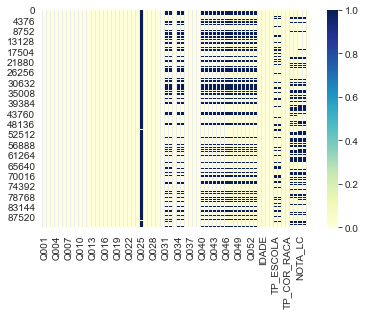

In [178]:
sns.heatmap(enem_selected.isnull(), cmap="YlGnBu")

Then, I will check which columns have any null values.

In [179]:
df_isnull_mean = np.mean(enem_selected.isnull()) 
df_isnull_mean[df_isnull_mean > 0]

Q025            0.990380
Q031            0.365347
Q032            0.365347
Q034            0.356847
Q035            0.356847
Q040            0.385535
Q041            0.385535
Q042            0.385535
Q043            0.385535
Q044            0.385535
Q045            0.385535
Q046            0.385535
Q047            0.385535
Q048            0.385535
Q049            0.385535
Q050            0.385535
Q051            0.385535
Q052            0.385535
Q053            0.385535
IDADE           0.000011
TP_ESCOLA       0.227571
IN_TP_ENSINO    0.227571
NOTA_CN         0.291431
NOTA_CH         0.291431
NOTA_LC         0.312859
NOTA_MT         0.312859
dtype: float64

Since the features I am interested in analyzing are the scores of the candidates, I will drop observations for which any score is Null for now. I am generally going to drop all other features for which the proportion of Nulls is greater than 0.35 (excluding the scores themselves). I chose to do so because, upon checking what the features tell us about the candidates, I decided that those features where not of particular interest. 

The school type ('TP_ESCOLA') and the type of institution ('IN_TP_ENSINO') are still interesting and are essential to the analises I wish to make. I will deal with them later.

In [180]:
col_missing = df_isnull_mean[df_isnull_mean > 0.35].index #obtain the columns that have more than 35% of null values
enem_selected = enem_selected.drop(col_missing, axis = 1) #drop these columns

obs_missing = enem_selected[(enem_selected['NOTA_CN'].isnull()) | (enem_selected['NOTA_CH'].isnull()) | (enem_selected['NOTA_LC'].isnull()) | (enem_selected['NOTA_MT'].isnull()) | (enem_selected['NU_NOTA_REDACAO'].isnull())].index
enem_selected = enem_selected.drop(obs_missing, axis = 0) #obtain observations for which any score is null and drop them

med_age = enem_selected['IDADE'].median()
enem_selected['IDADE'] = enem_selected['IDADE'].fillna(med_age) #fill the observations with null value for age with the median age

I will replace TP_ESCOLA (whether the school is private or public) and IN_TP_ESCOLA (regular, adult education or special school) by the mode value for each income category.

In [181]:
income_categories = enem_selected['Q003'].unique() #get the income categories from the answer to question Q003
enem_selected['TP_ESCOLA'] = enem_selected['TP_ESCOLA'].astype('category') #transform the TP_ESCOLA column (school type) in categorical variable

mode_per_category = {} #dict
for category in income_categories:
    m = enem_selected[enem_selected['Q003'] == category]['TP_ESCOLA'].describe().top #for each income category, obtain the most common school type
    mode_per_category[category] = m  #update dictionary
    
for row in enem_selected[enem_selected['TP_ESCOLA'].isnull()].index: 
    category = enem_selected.loc[row, 'Q003']
    enem_selected.loc[row, 'TP_ESCOLA'] = mode_per_category[category] #substitute null values with the mode for category

In [182]:
#Do the same as in the previous cell, but for the IN_TP_ENSINO

enem_selected['IN_TP_ENSINO'] = enem_selected['IN_TP_ENSINO'].astype('category')

mode_per_category = {}
for category in income_categories:
    m = enem_selected[enem_selected['Q003'] == category]['IN_TP_ENSINO'].describe().top
    mode_per_category[category] = m
    
for row in enem_selected[enem_selected['IN_TP_ENSINO'].isnull()].index:
    category = enem_selected.loc[row, 'Q003']
    enem_selected.loc[row, 'IN_TP_ENSINO'] = mode_per_category[category]

In [183]:
#enem_selected['NO_MUNICIPIO_RESIDENCIA'] = enem_selected['NO_MUNICIPIO_RESIDENCIA'].str.upper()

I will define a new column ('NOTA_MEDIA') with the mean score among the five areas for each candidate. 

In [184]:
enem_selected['NOTA_MEDIA'] = (enem_selected['NOTA_CN'] + enem_selected['NOTA_CH'] + enem_selected['NOTA_LC'] + enem_selected['NOTA_MT'] + enem_selected['NU_NOTA_REDACAO'])/5 #obtain the average score

# Exploratory data analysis

In the next two histograms, I am going to check the distribution of scores. In the first one, the distribution is shown regardless of school type. In the second one, however, the candidates were discrimated based on the type of school they attended. 1.0 represents public schools, while 2.0 represents private schools. 

<AxesSubplot:xlabel='NOTA_MEDIA', ylabel='Count'>

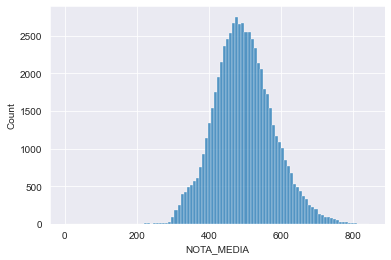

In [185]:
sns.histplot(data = enem_selected, x = 'NOTA_MEDIA', bins = 100) #plot the histogram for grades

<AxesSubplot:xlabel='NOTA_MEDIA', ylabel='Count'>

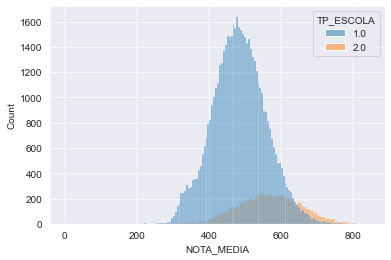

In [186]:
sns.histplot(data = enem_selected, x = 'NOTA_MEDIA', hue = 'TP_ESCOLA') #plot the histogram for the two different school types: public (1.0) or private (2.0)

Notice that the average score for private institutions is significantly higher than for public schools.

I wish to find out the average scores for different feature categories. I am going to start by calculating the average scores and standard deviation for each school type.

<AxesSubplot:xlabel='TP_ESCOLA', ylabel='NOTA_MEDIA'>

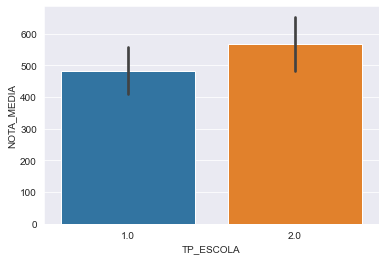

In [187]:
avg_per_type = enem_selected.groupby(['TP_ESCOLA'])[['NOTA_CN', 'NOTA_CH', 'NOTA_LC', 'NOTA_MT', 'NU_NOTA_REDACAO', 'NOTA_MEDIA']].mean()
std_per_type = enem_selected.groupby(['TP_ESCOLA'])[['NOTA_CN', 'NOTA_CH', 'NOTA_LC', 'NOTA_MT', 'NU_NOTA_REDACAO', 'NOTA_MEDIA']].std()
sns.barplot(x = 'TP_ESCOLA', y = 'NOTA_MEDIA', data = enem_selected, ci='sd') #bar plot of average scores for different types of school

We can see that private schools have an average score of over 550 points, while public schools have an average smaller than 500.

It is also interesting to ask ourselves if there is much variation among states.

<AxesSubplot:xlabel='UF_RESIDENCIA', ylabel='NOTA_MEDIA'>

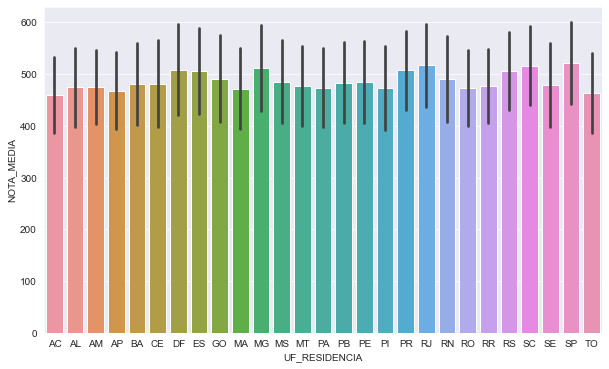

In [188]:
avg_per_type_state = enem_selected.groupby(['UF_RESIDENCIA'])[['NOTA_CN', 'NOTA_CH', 'NOTA_LC', 'NOTA_MT', 'NU_NOTA_REDACAO', 'NOTA_MEDIA']].mean()
std_per_type_state = enem_selected.groupby(['UF_RESIDENCIA'])[['NOTA_CN', 'NOTA_CH', 'NOTA_LC', 'NOTA_MT', 'NU_NOTA_REDACAO', 'NOTA_MEDIA']].std()

plt.figure(figsize=(10,6)) 
enem_selected = enem_selected.sort_values(['UF_RESIDENCIA'])
sns.barplot(x = 'UF_RESIDENCIA', y = 'NOTA_MEDIA', data = enem_selected, ci='sd') #bar plot for score distrubution for different States

Since there are 26 states plus the Federal District, it is better, for analysis purposes, to divide the states into the five regions in which Brazil is usually divided. Let's analyze it, then:

<AxesSubplot:xlabel='REGION', ylabel='NOTA_MEDIA'>

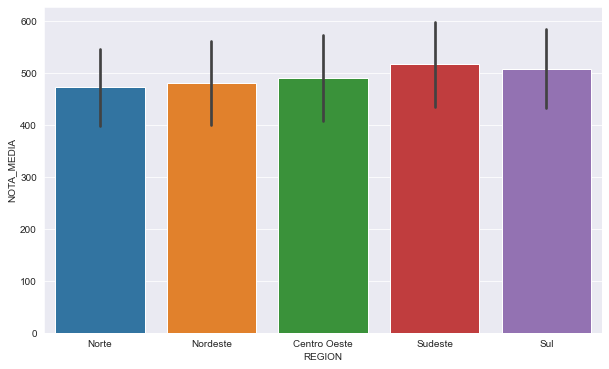

In [189]:
region_mapping = {'RS':'Sul', 'SC':'Sul', 'PR':'Sul', 'SP':'Sudeste', 'RJ':'Sudeste', 'MG':'Sudeste', 'ES':'Sudeste', 'BA':'Nordeste', 'SE':'Nordeste', 'AL':'Nordeste', 'PE':'Nordeste', 'PB':'Nordeste', 'RN':'Nordeste', 'CE':'Nordeste', 'MA':'Nordeste', 'PI':'Nordeste', 'MS':'Centro Oeste', 'MT': 'Centro Oeste', 'GO':'Centro Oeste', 'DF':'Centro Oeste', 'AM':'Norte', 'PA':'Norte', 'AC':'Norte', 'RO':'Norte', 'RR':'Norte', 'TO':'Norte', 'AP':'Norte'} #dictionary mapping each state to its region
enem_selected['REGION'] = enem_selected['UF_RESIDENCIA'].replace(region_mapping) #creates a column with the region of each candidate

plt.figure(figsize=(10,6))
sns.barplot(x = 'REGION', y = 'NOTA_MEDIA', data = enem_selected, ci='sd') #bar plot of the score distribution for each region

Note that the North is the region that has the smallest average grades, while the Southeast hast the largest. In fact, the only two regions whose average is above 500 points are the Southeast and the South. We can see a significant difference in grades among the regions. 

It is interesting to investigate how social differences affect the average grade. The next graph shows the differences in average score by ethnicity. Is important to emphasize that racial and socioeconomic factors are strongly correlated in Brazil, as they are in much of the world. People with different ethnic backgrounds may have, in average, different opportunities. That is why it is interesting to see how these differents may be reflected on the average grades by ethnicity.

The code works as follows: 

0 - Did not declare ethnicity;

1 - Branco;

2 - Preto;

3 - Pardo;

4 - Amarelo;

5 - Indígena. 

I did not translate the ethnicities into English, since they reflect a very specific Brazilian context and translating them would be very misleading. 

<AxesSubplot:xlabel='TP_COR_RACA', ylabel='NOTA_MEDIA'>

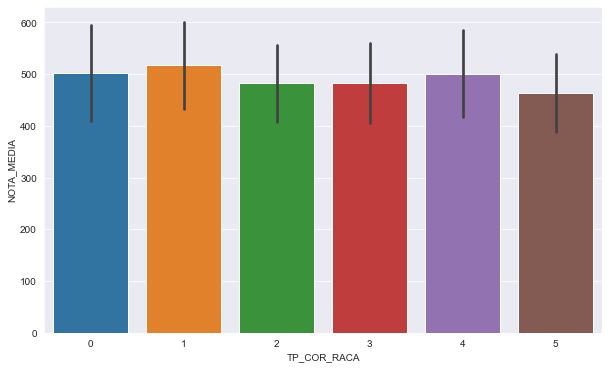

In [190]:
avg_per_race = enem_selected.groupby('TP_COR_RACA')[['NOTA_CN', 'NOTA_CH', 'NOTA_LC', 'NOTA_MT', 'NU_NOTA_REDACAO', 'NOTA_MEDIA']].mean()
std_per_race = enem_selected.groupby('TP_COR_RACA')[['NOTA_CN', 'NOTA_CH', 'NOTA_LC', 'NOTA_MT', 'NU_NOTA_REDACAO', 'NOTA_MEDIA']].std()

plt.figure(figsize=(10,6))
sns.barplot(x = 'TP_COR_RACA', y = 'NOTA_MEDIA', data = enem_selected, ci='sd')

It is specially interesting to analyze how the grades are distributed according to household income. 

<AxesSubplot:xlabel='Q003', ylabel='NOTA_MEDIA'>

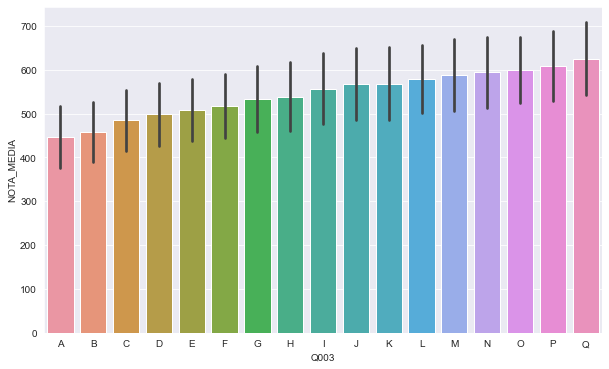

In [191]:
avg_per_income = enem_selected.groupby(['Q003'])[['NOTA_CN', 'NOTA_CH', 'NOTA_LC', 'NOTA_MT', 'NU_NOTA_REDACAO', 'NOTA_MEDIA']].mean()
std_per_income = enem_selected.groupby(['Q003'])[['NOTA_CN', 'NOTA_CH', 'NOTA_LC', 'NOTA_MT', 'NU_NOTA_REDACAO', 'NOTA_MEDIA']].std()

plt.figure(figsize=(10,6))
enem_selected = enem_selected.sort_values(['Q003'])
sns.barplot(x = 'Q003', y = 'NOTA_MEDIA', data = enem_selected, ci='sd')

It is fascinating to see that the average score increases a lot with the average household income. In fact, every income bracket has an average score greater  Specially, the increase is steeper for the lowest classes.

Since there are 17 different categories of income, I will change the categories a bit. The categories will become as follows:

1 - No income to 1 minimum income;

2 - Between 1 and 5 times the minimum income;

3 - Between 5 and 10 times the minimum income;

4 - Between 10 and 15 times the minimum income;

5 - Between 15 and 20 times the minimum income;

6 - More than 20 times the minimum income; 

<AxesSubplot:xlabel='RENDA', ylabel='NOTA_MEDIA'>

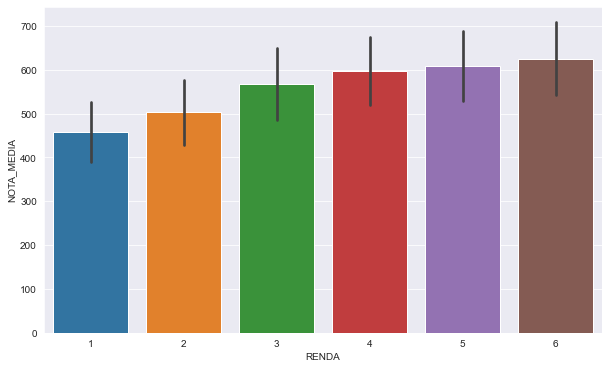

In [192]:
income_mapping = {'A':1, 'B':1, 'C':2, 'D':2, 'E':2, 'F':2, 'G':2, 'H':2, 'I':3, 'J':3, 'K':3, 'L':3, 'M':3, 'N':4, 'O':4, 'P':5, 'Q':6}
enem_selected['RENDA'] = enem_selected['Q003'].replace(income_mapping)
plt.figure(figsize=(10,6))
enem_selected = enem_selected.sort_values(['RENDA'])
sns.barplot(x = 'RENDA', y = 'NOTA_MEDIA', data = enem_selected, ci='sd')

With the exploratory data analysis performed above, we could see that there are many general trends in the ENEM scores based on socioeconomic factors. While it may not be very helpful to try to predict the ENEM outcome for one particular individual, it may be interesting to train machine learning models in order to predict the scores and detect general trends. That is what I am going to do in the remainder of this project.

First, I will transform every categorial column into categorical values (using dummy variables). For that, I will use the LabelEncoder function from sklearn.preprocessing.

In [193]:
from sklearn.preprocessing import LabelEncoder

In [194]:
enem_selected.columns

Index(['Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009',
       'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018',
       'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q026', 'Q027', 'Q028',
       'Q029', 'Q030', 'Q033', 'Q036', 'Q037', 'Q038', 'Q039', 'UF_RESIDENCIA',
       'IDADE', 'TP_SEXO', 'NACIONALIDADE', 'TP_ESCOLA', 'IN_TP_ENSINO',
       'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'NOTA_CN', 'NOTA_CH', 'NOTA_LC',
       'NOTA_MT', 'NU_NOTA_REDACAO', 'NOTA_MEDIA', 'REGION', 'RENDA'],
      dtype='object')

In [196]:
le = LabelEncoder()
encoded_enem_selected = enem_selected[['Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009',
       'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018',
       'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q026', 'Q027', 'Q028',
       'Q029', 'Q030', 'Q033', 'Q036', 'Q037', 'Q038', 'Q039', 'UF_RESIDENCIA', 'TP_SEXO',
       'NACIONALIDADE', 'TP_ESCOLA', 'IN_TP_ENSINO', 'TP_ESTADO_CIVIL',
       'TP_COR_RACA']].apply(le.fit_transform)

encoded_enem_selected[['IDADE', 'NOTA_CN', 'NOTA_CH', 'NOTA_LC', 'NOTA_MT',
       'NU_NOTA_REDACAO', 'NOTA_MEDIA']] = enem_selected[['IDADE', 'NOTA_CN', 'NOTA_CH', 'NOTA_LC', 'NOTA_MT',
       'NU_NOTA_REDACAO', 'NOTA_MEDIA']]

Firstly, I will use a tree model in order to predict the scores. This seems to be particularly interesting in this case, due to the presence of several categorical variables. I wil use a random forest model. 

# Tree model

In [197]:
from sklearn.model_selection import train_test_split

X = encoded_enem_selected[['Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009',
       'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018',
       'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q026', 'Q027', 'Q028',
       'Q029', 'Q030', 'Q033', 'Q036', 'Q037', 'Q038', 'Q039', 'UF_RESIDENCIA', 'IDADE', 'TP_SEXO',
       'NACIONALIDADE', 'TP_ESCOLA', 'IN_TP_ENSINO', 'TP_ESTADO_CIVIL',
       'TP_COR_RACA']]
y = encoded_enem_selected['NOTA_MEDIA']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

I will decide what is the ideal number of estimators for our random forest. For that, I will calculate the root mean squared error as a function of the number of estimators. For this part, I only used 100,000 observations, due to the large computational cost. 

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

random_forest = []

for i in  range(1, 60):
    rfr = RandomForestRegressor(n_estimators = i)
    rfr.fit(X_train, y_train)
    rfr_pred = rfr.predict(X_test)
    random_forest.append([i, np.sqrt(metrics.mean_squared_error(y_test, rfr_pred))])

<AxesSubplot:xlabel='i', ylabel='Root mean squared error'>

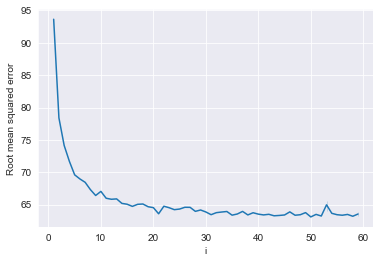

In [133]:
random_forest_pd = pd.DataFrame(random_forest, columns = ['i', 'Root mean squared error'])
sns.lineplot(x = 'i', y = 'Root mean squared error', data = random_forest_pd)

I will chose i = 40 for the number of estimators, since the MSE does not seem to decrease much after that.

In [129]:
rfr = RandomForestRegressor(n_estimators = 40)
rfr.fit(X_train, y_train)
rfr_pred = rfr.predict(X_test)
random_forest.append([i, np.sqrt(metrics.mean_squared_error(y_test, rfr_pred))])

In [130]:
print('MAE:', metrics.mean_absolute_error(y_test, rfr_pred)) #Mean absolute error
print('MSE:', metrics.mean_squared_error(y_test, rfr_pred)) #Mean squared error
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rfr_pred))) #Root mean squared error

MAE: 51.95989942038495
MSE: 4284.363612601557
RMSE: 65.45505032158754


In [123]:
rfr_pred_df = pd.DataFrame(rfr_pred)
rfr_pred_df.columns = ['PREDICAO']
rfr_pred_df.index = y_test.index

In [134]:
y_rfr = pd.concat([y_test, rfr_pred_df], axis = 1)
print(y_rfr)

       NOTA_MEDIA    PREDICAO
23760      473.46  579.921714
61217      490.30  542.000000
87315      529.70  604.058286
68766      549.58  490.460571
98455      645.46  593.480571
...           ...         ...
20782      375.94  483.808571
52951      485.18  529.464571
39510      570.10  520.918857
46041      516.88  491.067429
18940      414.56  474.525714

[3810 rows x 2 columns]


<AxesSubplot:xlabel='NOTA_MEDIA', ylabel='PREDICAO'>

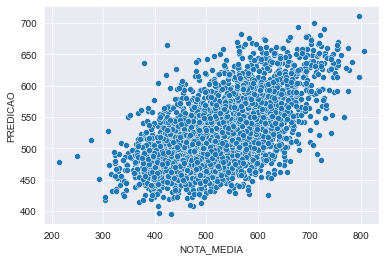

In [135]:
sns.scatterplot(data = y_rfr, x = 'NOTA_MEDIA', y = 'PREDICAO')

Some comments: the model was wrong, in average, buy 51.9 points. The root mean squared error was 65.5 points. The graph shows that, although the model does not perfectly predict the scores (and no one said that it should!), it is good at detecting general trends. The most important result is that there is something to be learned by our model. The scores are not completely random. Although the features chosen here do not perfectly predict the scores (as already expected), they are correlated to the final score - and the fact that the model was able to learn how to predict scores to a certain extent shows this.

I will also use a neural network and compare it to the tree model. 

# Neural Network

In [136]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [163]:
model = Sequential()
model.add(Dense(8, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1))

In [164]:
model.compile(optimizer = 'Adam', loss = 'mse')

In [165]:
model.fit(x = X_train, y = y_train, epochs = 300)

Epoch 1/200
2263/2263 [==============================] - 2s 612us/step - loss: 53198.0351
Epoch 2/200
2263/2263 [==============================] - 1s 609us/step - loss: 6760.9084
Epoch 3/200
2263/2263 [==============================] - 1s 612us/step - loss: 6203.0369
Epoch 4/200
2263/2263 [==============================] - 1s 611us/step - loss: 6010.8242
Epoch 5/200
2263/2263 [==============================] - 1s 612us/step - loss: 5887.3935
Epoch 6/200
2263/2263 [==============================] - 1s 611us/step - loss: 5802.2626
Epoch 7/200
2263/2263 [==============================] - 1s 629us/step - loss: 5675.1229
Epoch 8/200
2263/2263 [==============================] - 2s 727us/step - loss: 5595.7849
Epoch 9/200
2263/2263 [==============================] - 2s 735us/step - loss: 5571.1232
Epoch 10/200
2263/2263 [==============================] - 1s 610us/step - loss: 5463.5848
Epoch 11/200
2263/2263 [==============================] - 1s 661us/step - loss: 5402.5541
Epoch 12/200
2263/

2263/2263 [==============================] - 1s 597us/step - loss: 4299.0318
Epoch 93/200
2263/2263 [==============================] - 1s 623us/step - loss: 4276.7242
Epoch 94/200
2263/2263 [==============================] - 2s 779us/step - loss: 4289.4569
Epoch 95/200
2263/2263 [==============================] - 3s 1ms/step - loss: 4256.3079
Epoch 96/200
2263/2263 [==============================] - 3s 2ms/step - loss: 4202.4541
Epoch 97/200
2263/2263 [==============================] - 3s 1ms/step - loss: 4284.5791
Epoch 98/200
2263/2263 [==============================] - 3s 1ms/step - loss: 4336.8777
Epoch 99/200
2263/2263 [==============================] - 3s 1ms/step - loss: 4241.9020
Epoch 100/200
2263/2263 [==============================] - 3s 1ms/step - loss: 4271.0602
Epoch 101/200
2263/2263 [==============================] - 3s 1ms/step - loss: 4246.5101
Epoch 102/200
2263/2263 [==============================] - 3s 1ms/step - loss: 4263.6760
Epoch 103/200
2263/2263 [===========

2263/2263 [==============================] - 3s 1ms/step - loss: 4249.9379
Epoch 183/200
2263/2263 [==============================] - 3s 1ms/step - loss: 4240.1556
Epoch 184/200
2263/2263 [==============================] - 3s 1ms/step - loss: 4270.5424
Epoch 185/200
2263/2263 [==============================] - 3s 1ms/step - loss: 4223.7127
Epoch 186/200
2263/2263 [==============================] - 3s 1ms/step - loss: 4198.0559
Epoch 187/200
2263/2263 [==============================] - 1s 603us/step - loss: 4264.2521
Epoch 188/200
2263/2263 [==============================] - 1s 604us/step - loss: 4242.7236
Epoch 189/200
2263/2263 [==============================] - 1s 604us/step - loss: 4254.0975
Epoch 190/200
2263/2263 [==============================] - 1s 602us/step - loss: 4232.7308
Epoch 191/200
2263/2263 [==============================] - 1s 604us/step - loss: 4239.4758
Epoch 192/200
2263/2263 [==============================] - 1s 613us/step - loss: 4205.1304
Epoch 193/200
2263/2263

In [166]:
nn_pred = model.predict(X_test)

In [167]:
nn_pred_df = pd.DataFrame(nn_pred, columns = ['PREDICAO'])

In [168]:
y_nn = pd.concat([y_test, nn_pred_df], axis = 1)

In [169]:
print('MAE:', metrics.mean_absolute_error(y_test, nn_pred))
print('MSE:', metrics.mean_squared_error(y_test, nn_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, nn_pred)))

MAE: 51.77584994803201
MSE: 4238.757016435666
RMSE: 65.10573720061593
